In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Predictive: XGBoost with `No Sales Histroical Data`

In [32]:
import pandas as pd
import numpy as np

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
pd.set_option('display.max_columns', None)

#### Load the experiment df `ca1_train` and `ca1_test`

In [5]:
ca1_train = pd.read_parquet('../data/interim/predictive_ca1_train.to_parquet')
ca1_test = pd.read_parquet('../data/interim/predictive_ca1_test.to_parquet')

In [6]:
import sys
sys.path.insert(0, '../src')

#### Import the `preprocess` function to preprocess the data
- Extract date-related features from the `date` column
- Add `seasonality-feature`
- `Label Encoding` the categorical features
- Drop `id`, `date`, `wm_yr_wk`, `d`,  `event_name`, `event_type` features

In [35]:
from features.data_prep import preprocess_no_sales_historical

In [36]:
df_train, item_id_encoder, dept_id_encoder, store_id_encoder, state_id_encoder, cat_id_encoder = preprocess_no_sales_historical(ca1_train.copy())

In [37]:
df_test = preprocess_no_sales_historical(ca1_test.copy())[0]

In [49]:
df_test

,item_id,dept_id,cat_id,store_id,state_id,sales,sell_price,total_sales,year,month,week_number,day_of_week,season_sin,season_cos
47107050,1437,3,1,0,0,0,8.26,0.00,2015,4,222,6,0.866025,-0.500000
47107051,1438,3,1,0,0,0,3.97,0.00,2015,4,222,6,0.866025,-0.500000
47107052,1439,3,1,0,0,0,2.97,0.00,2015,4,222,6,0.866025,-0.500000
47107053,1440,3,1,0,0,4,4.64,18.56,2015,4,222,6,0.866025,-0.500000
47107054,1441,3,1,0,0,3,2.88,8.64,2015,4,222,6,0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59275604,1432,2,0,0,0,2,2.98,5.96,2016,5,279,6,0.500000,-0.866025
59275605,1433,2,0,0,0,0,2.48,0.00,2016,5,279,6,0.500000,-0.866025
59275606,1434,2,0,0,0,1,3.98,3.98,2016,5,279,6,0.500000,-0.866025
59275607,1435,2,0,0,0,1,1.28,1.28,2016,5,279,6,0.500000,-0.866025


#### Import `extract_features_target` function

In [39]:
from features.data_prep import extract_features_target

In [40]:
X_train, X_test, y_train, y_test = extract_features_target(df_train, df_test, 'total_sales')

#### Imoprt the `XGBRegressor`, and use `RMSE` as a performance metrics.

In [41]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error

#### Run the experiment of the `learning_rate` and `max_depth` features:
- `learning_rate`: from range 0.16 - 0.32 with a step of 0.05.
- `max_depth`: from range 3 to 10.

In [16]:
learning_rate = np.arange(0.16, 0.32, 0.05)
max_depth = np.arange(3, 10)

for lr in learning_rate:
    for md in max_depth:
        xgb_ht = XGBRegressor(objective = 'reg:tweedie', learning_rate = lr, max_depth = md, subsample = 0.7, 
                            colsample_bytree = 0.7, n_estimators = 100) 
        
        xgb_ht.fit(X_train,y_train)
        y_pred = xgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred, squared=False)

        print(f"Learning Rate: {lr}, Max Depth: {md},\n  RMSE Sales: {rmse}")
        print("\n")

Learning Rate: 0.16, Max Depth: 3,
  RMSE Sales: 10.830657917071331


Learning Rate: 0.16, Max Depth: 4,
  RMSE Sales: 10.715895770074331


Learning Rate: 0.16, Max Depth: 5,
  RMSE Sales: 10.58116331547848


Learning Rate: 0.16, Max Depth: 6,
  RMSE Sales: 10.346175178869975


Learning Rate: 0.16, Max Depth: 7,
  RMSE Sales: 10.185253772531865


Learning Rate: 0.16, Max Depth: 8,
  RMSE Sales: 10.120966862343987


Learning Rate: 0.16, Max Depth: 9,
  RMSE Sales: 9.96521356239281


Learning Rate: 0.21000000000000002, Max Depth: 3,
  RMSE Sales: 10.801724668520162


Learning Rate: 0.21000000000000002, Max Depth: 4,
  RMSE Sales: 10.607785968771328


Learning Rate: 0.21000000000000002, Max Depth: 5,
  RMSE Sales: 10.390842886307327


Learning Rate: 0.21000000000000002, Max Depth: 6,
  RMSE Sales: 10.275734411280505


Learning Rate: 0.21000000000000002, Max Depth: 7,
  RMSE Sales: 10.091344713272274


Learning Rate: 0.21000000000000002, Max Depth: 8,
  RMSE Sales: 10.11032763228556


Lear

#### The best parameters for
- `learning_rate`: 0.26
- `max_depth`: 9

In [42]:
xgb = XGBRegressor(objective='reg:tweedie', learning_rate=0.26, max_depth=9, subsample=0.7, colsample_bytree=0.7, n_estimators=100)
xgb.fit(X_train,y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', verbose=10)

/Users/narongvatchingpayakmon/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:10.90800
[10]	validation_0-rmse:6.05378
[20]	validation_0-rmse:3.10279
[30]	validation_0-rmse:2.23766
[40]	validation_0-rmse:1.98806
[50]	validation_0-rmse:1.84774
[60]	validation_0-rmse:1.79436
[70]	validation_0-rmse:1.75273
[80]	validation_0-rmse:1.70763
[90]	validation_0-rmse:1.68407
[99]	validation_0-rmse:1.65718


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.26, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

#### Plot the Feature Importance

In [29]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

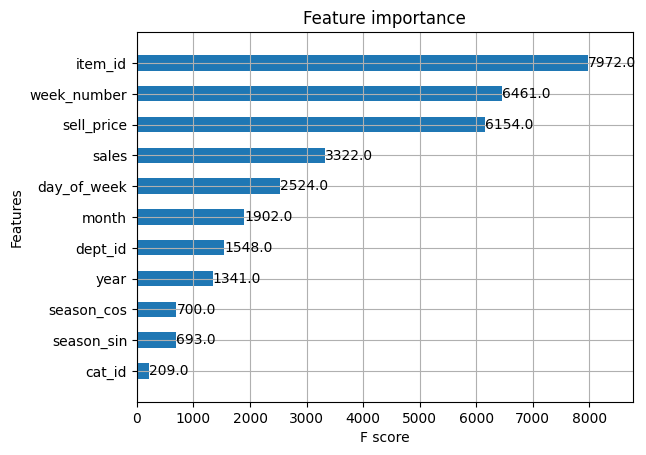

In [43]:
plot_importance(xgb, height=0.5)

#### Trial the observation with missing value in `sales`, `ema`, `rolling_std`, and `lag`

In [44]:
obs = X_test.iloc[[1]]
obs.iloc[:, 11:] = np.nan

In [45]:
obs.loc[:, 'sales'] = 0.879433

In [46]:
obs

,item_id,dept_id,cat_id,store_id,state_id,sales,sell_price,year,month,week_number,day_of_week,season_sin,season_cos
47107051,1438,3,1,0,0,0.879433,3.97,2015,4,222,6,NaN,NaN


In [47]:
y_pred = xgb.predict(obs)
y_pred

array([1.1784134e-12], dtype=float32)

In [48]:
y_pred = xgb.predict(X_test)

predicted_total_sales = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
predicted_total_sales

,y_test,y_pred
47107050,0.00,1.542556e-12
47107051,0.00,1.188272e-12
47107052,0.00,5.762473e-13
47107053,18.56,2.082002e+01
47107054,8.64,8.631824e+00
...,...,...
59275604,5.96,7.675947e+00
59275605,0.00,1.208920e-12
59275606,3.98,4.315636e+00
59275607,1.28,1.153275e+00
